In [1]:
import os
import kagglehub

path = kagglehub.dataset_download("fakhrealam9537/leaf-disease-segmentation-dataset")
print("Path to dataset files:", path)

aug_data_dir = os.path.join(path, "aug_data", "aug_data")  
if not os.path.exists(aug_data_dir):
    aug_data_dir = os.path.join(path, "aug_data")  

print("Augmented Data Directory:", aug_data_dir)
if os.path.exists(aug_data_dir):
    print(os.listdir(aug_data_dir))

image_dir = os.path.join(aug_data_dir, "images")
mask_dir = os.path.join(aug_data_dir, "masks")

print("Images Directory Exists:", os.path.exists(image_dir))
print("Masks Directory Exists:", os.path.exists(mask_dir))

if os.path.exists(image_dir):
    image_source_dir = image_dir
else:
    image_source_dir = None
    print("Error: Images directory not found!")

if os.path.exists(mask_dir):
    mask_source_dir = mask_dir
else:
    mask_source_dir = None
    print("Error: Masks directory not found!")

print("Image Source Directory:", image_source_dir)
print("Mask Source Directory:", mask_source_dir)

Path to dataset files: /kaggle/input/leaf-disease-segmentation-dataset
Augmented Data Directory: /kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data
['images', 'masks']
Images Directory Exists: True
Masks Directory Exists: True
Image Source Directory: /kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images
Mask Source Directory: /kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/masks


<ipython-input-5-1ed2ed14b692>:246: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))
Evaluating UNet:   0%|        

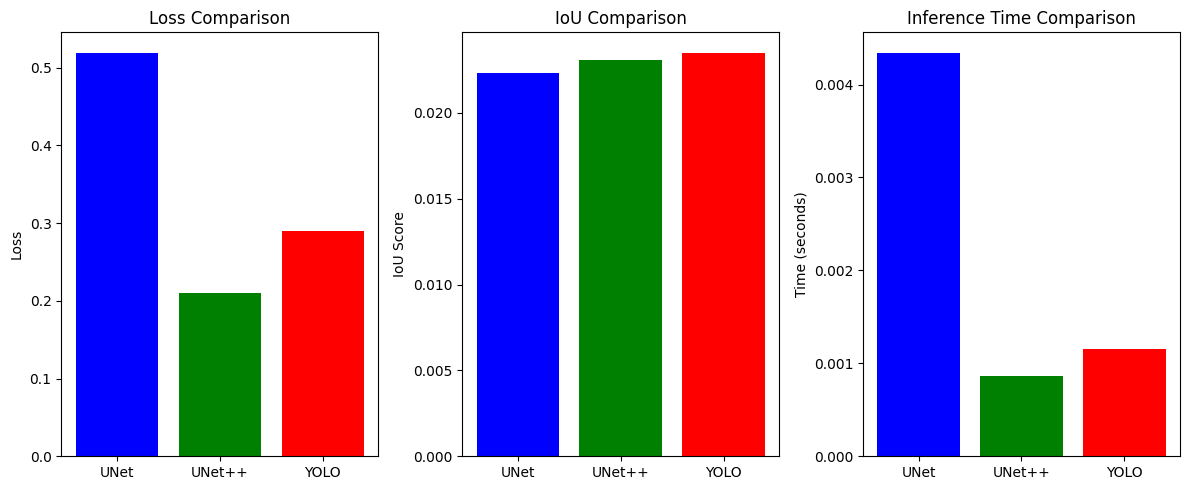

In [5]:
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import jaccard_score  
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

IMG_WIDTH, IMG_HEIGHT = 256, 256

# Define custom dataset class
class LeafDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))  # Ensure correct pairing
        self.mask_filenames = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(img_path).convert("RGB")  # Ensure 3 channels
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define transformations (modify as needed)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images & masks
    transforms.ToTensor(),  # Convert to tensors
])

# Define dataset and DataLoader
image_dir = "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images"
mask_dir = "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/masks"

test_dataset = LeafDataset(image_dir, mask_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)


# ==================================
# UNET Model Definition
# ==================================
# UNET-PARTS

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


# ==================================
# UNET++ Model Definition
# ==================================
class UNetPlusPlus(nn.Module):
    def __init__(self, num_classes=2, in_channels=3):
        super(UNetPlusPlus, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.conv1 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(192, 64, kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):

        enc1 = self.encoder(x)

        dec1 = self.conv1(enc1)

        dec2 = self.conv2(torch.cat([enc1, dec1], dim=1))

        dec3 = self.conv3(torch.cat([enc1, dec1, dec2], dim=1))

        output = self.final_conv(dec3)

        return output


# ==================================
# YOLOv11 Model Definition
# ==================================
class YOLOv11(nn.Module):
    def __init__(self, num_classes):
        super(YOLOv11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=1),
            nn.Upsample(
                size=(IMG_HEIGHT, IMG_WIDTH), mode="bilinear", align_corners=True
            ),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.decoder(x)
        return x


# ==================================
# Model Evaluation
# ==================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained models
def load_model(model_class, path, num_classes=39, in_channels=3):
    if model_class == UNet:
        model = model_class(n_classes=num_classes, n_channels=in_channels).to(device)  
    elif model_class == UNetPlusPlus:
        model = model_class(num_classes=num_classes, in_channels=in_channels).to(device)  
    elif model_class == YOLOv11:
        model = model_class(num_classes=num_classes).to(device)  
    else:
        raise ValueError(f"Unknown model class: {model_class}")

    try:
        model.load_state_dict(torch.load(path, map_location=device))
        model.eval()
    except Exception as e:
        print(f"Error loading {model_class.__name__}: {e}")

    return model


unet = load_model(UNet, "/kaggle/input/unet/pytorch/default/1/UNet.pth")
unetpp = load_model(UNetPlusPlus, "/kaggle/input/unetpp/pytorch/default/1/best_unetplusplus_model.pth")
yolo = load_model(YOLOv11, "/kaggle/input/yolo/pytorch/default/1/best_model_yolov11.pth")


def evaluate_model(model, test_loader, criterion, num_classes):
    total_loss, total_iou, total_time = 0, 0, 0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc=f"Evaluating {model.__class__.__name__}"):
            images, masks = images.to(device), masks.to(device)
            start_time = time.time()
            outputs = model(images)
            end_time = time.time()

            total_time += (end_time - start_time)
            outputs = outputs.permute(0, 2, 3, 1).reshape(-1, num_classes)
            masks = masks.long().view(-1)
            total_loss += criterion(outputs, masks).item()
            total_iou += jaccard_score(
                masks.cpu().numpy(), torch.argmax(outputs, dim=1).cpu().numpy(), 
                average="macro", labels=range(num_classes)
            )

    return total_loss / len(test_loader), total_iou / len(test_loader), total_time / len(test_loader)


criterion = nn.CrossEntropyLoss()

unet_metrics = evaluate_model(unet, test_loader, criterion, num_classes=39)
unetpp_metrics = evaluate_model(unetpp, test_loader, criterion, num_classes=39)
yolo_metrics = evaluate_model(yolo, test_loader, criterion, num_classes=39)

# ==================================
# Results Visualization
# ==================================
models = ["UNet", "UNet++", "YOLO"]
losses, ious, times = zip(unet_metrics, unetpp_metrics, yolo_metrics)

plt.figure(figsize=(12, 5))
for i, (metric, title, ylabel) in enumerate(zip([losses, ious, times], 
                                                 ["Loss Comparison", "IoU Comparison", "Inference Time Comparison"], 
                                                 ["Loss", "IoU Score", "Time (seconds)"])):
    plt.subplot(1, 3, i + 1)
    plt.bar(models, metric, color=["blue", "green", "red"])
    plt.title(title)
    plt.ylabel(ylabel)

plt.tight_layout()
plt.show()
